# Light Curtain Sweep Correction

In this example, we show how we predict a prior DPV from an RGB image from our ILIM dataset, and correct depth using real light curtain data

In [22]:
# Python
import numpy as np
import time
import cv2
import math
import copy
import sys
sys.path.append("../")
sys.path.append("../external/lcsim/python")

# Custom
try:
    import kittiloader.kitti as kitti
    import kittiloader.batch_loader as batch_loader
except:
    import kitti
    import batch_loader

# Data Loading Module
import torch.multiprocessing
import torch.multiprocessing as mp
from torch.multiprocessing import Process, Queue, Value, cpu_count
import utils.img_utils as img_utils
import utils.misc_utils as misc_utils
import external.utils_lib.utils_lib as kittiutils
import torch.nn.functional as F
import json
from easydict import EasyDict
import warping.view as View
import torchvision.transforms as transforms
from models.get_model import get_model
from utils.torch_utils import bias_parameters, weight_parameters, \
    load_checkpoint, save_checkpoint, AdamW
from lc import light_curtain
from external.perception_lib import viewer
import ipyvolume.pylab as p3
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from matplotlib import interactive
interactive(True)
%matplotlib notebook

In [2]:
def load_datum(path, name, indx):
    datum = dict()
    # Generate Paths
    date = name.split("_drive")[0]
    index_str = "%06d" % (indx,)
    sweep_path = path + "/" + date + "/" + name + "/sweep/" + index_str + ".npy"
    left_img_path = path + "/" + date + "/" + name + "/left_img/" + index_str + ".png"
    right_img_path = path + "/" + date + "/" + name + "/right_img/" + index_str + ".png"
    nir_img_path = path + "/" + date + "/" + name + "/nir_img/" + index_str + ".png"
    velo_path = path + "/" + date + "/" + name + "/lidar/" + index_str + ".bin"
    json_path = path + "/" + date + "/" + name + "/calib.json"

    # Load Data
    datum["sweep_arr"] = np.load(sweep_path).astype(np.float32)
    datum["velodata"] = np.fromfile(velo_path, dtype=np.float32).reshape((-1, 4))
    datum["left_img"] = cv2.imread(left_img_path)
    datum["right_img"] = cv2.imread(right_img_path)
    datum["nir_img"] = cv2.imread(nir_img_path)
    datum["nir_img"] = cv2.cvtColor(datum["nir_img"], cv2.COLOR_BGR2GRAY)
    datum["left_img"] = cv2.resize(datum["left_img"], None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
    datum["nir_img"] = cv2.resize(datum["nir_img"], None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    datum["right_img"] = cv2.resize(datum["right_img"], None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
    # Load Json
    with open(json_path) as json_file:
        calib = json.load(json_file)
    datum["large_intr"] = np.array(calib["left_P"]).astype(np.float32) / 4.
    datum["large_intr"][2,2] = 1.
    datum["M_velo2left"] = np.linalg.inv(np.array(calib["left_2_lidar"]).astype(np.float32))
    datum["large_size"] = [datum["left_img"].shape[1], datum["left_img"].shape[0]]
    datum["M_left2right"] = np.array(calib["left_2_right"]).astype(np.float32)
    datum["M_right2left"] = np.linalg.inv(datum["M_left2right"])
    datum["M_left2LC"] = np.array(calib["left_2_lc"]).astype(np.float32)
    datum["M_right2LC"] = np.matmul(datum["M_right2left"], datum["M_left2LC"])
    datum["D_lc"] = np.array([-0.033918, 0.027494, -0.001691, -0.001078, 0.000000]).astype(np.float32)
    datum["K_lc"] = np.array([
        [893.074542/2, 0.000000, 524.145998/2],
        [0.000000, 893.177518/2, 646.766885/2],
        [0.000000, 0.000000, 1.000000]
    ]).astype(np.float32)
    datum["K_lc"] /= 2
    datum["K_lc"][2,2] = 1.
    datum["lc_size"] = [256, 320]
    # datum["lc_size"] = [512, 640]
    datum["M_velo2right"] = np.matmul(datum["M_left2right"], datum["M_velo2left"])
    datum["M_velo2LC"] = np.matmul(datum["M_left2LC"], datum["M_velo2left"])
    datum["d_candi"] = img_utils.powerf(3, 18, 64, 1.)
    datum["d_candi_up"] = img_utils.powerf(3, 18, 128, 1.)
    datum["M_LC2laser"] = np.array([
        [0.999998660642566, -0.001633815794167618, 0.0000012624935166435589, 0.19989228458449756],
        [0.001633815794167618, 0.9999974722179782, -0.0015454518952038837, 0.00034823987032651596],
        [0.0000012624935166435595, 0.0015454518952038839, 0.9999988015754122, -0.014010022846647934],
        [0,0,0,1]
    ]).astype(np.float32)
    datum["M_LC2left"] = np.linalg.inv(datum["M_left2LC"])

    # Try to double the size of sweep_arr 
    sweep_arr_large = np.zeros((datum["sweep_arr"].shape[0], datum["sweep_arr"].shape[1]*2, datum["sweep_arr"].shape[2]*2, datum["sweep_arr"].shape[3]))
    for i in range(0, sweep_arr_large.shape[0]):
        sweep_arr_large[i,:,:,0] = cv2.resize(datum["sweep_arr"][i,:,:,0], None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        sweep_arr_large[i,:,:,1] = cv2.resize(datum["sweep_arr"][i,:,:,1], None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    datum["sweep_arr_large"] = sweep_arr_large
    datum["K_lc_large"] = datum["K_lc"]*2
    datum["K_lc_large"][2,2] = 1.
    datum["lc_size_large"] = [512, 640]
    datum["nir_img_large"] = cv2.imread(nir_img_path)
    datum["nir_img_large"] = cv2.cvtColor(datum["nir_img_large"], cv2.COLOR_BGR2GRAY)

    # Easydict
    datum = EasyDict(datum)
    return datum

In [3]:
# Load (Be sure to download from http://megatron.sp.cs.cmu.edu/raaj/data3/Public/raaj/sweep_data.zip)
datum = load_datum("/media/raaj/Storage/sweep_data", "2021_03_05_drive_0004_sweep", 10)
#datum = load_datum("/media/raaj/Storage/sweep_data", "2021_03_12_drive_0004_sweep", 81)
#datum = load_datum("/media/raaj/Storage/sweep_data", "2021_03_12_drive_0004_sweep", 42)

In [4]:
# Undistort Sweep Arr (only small one)
datum.nir_img = cv2.undistort(datum.nir_img, datum.K_lc, datum.D_lc)
for i in range(0, datum.sweep_arr.shape[0]):
    datum.sweep_arr[i, :,:, 0] = cv2.undistort(datum.sweep_arr[i, :,:, 0], datum.K_lc, datum.D_lc)
    datum.sweep_arr[i, :,:, 1] = cv2.undistort(datum.sweep_arr[i, :,:, 1], datum.K_lc, datum.D_lc)

# Depths
large_params = {"filtering": 2, "upsample": 0}
datum["left_depth"] = kittiutils.generate_depth(datum.velodata, datum.large_intr, datum.M_velo2left, datum.large_size[0], datum.large_size[1], large_params)
datum["right_depth"] = kittiutils.generate_depth(datum.velodata, datum.large_intr, datum.M_velo2right, datum.large_size[0], datum.large_size[1], large_params)
datum["lc_depth"] = kittiutils.generate_depth(datum.velodata, datum.K_lc, datum.M_velo2LC, datum.lc_size[0], datum.lc_size[1], large_params)
datum["lc_depth_large"] = kittiutils.generate_depth(datum.velodata, datum.K_lc_large, datum.M_velo2LC, datum.lc_size_large[0], datum.lc_size_large[1], large_params)

# Upsample Depth
datum.left_depth = kittiutils.upsample_depth(datum.left_depth, 2, 0.5)
datum.right_depth = kittiutils.upsample_depth(datum.right_depth, 2, 0.5)
datum.lc_depth = kittiutils.upsample_depth(datum.lc_depth, 2, 0.5)
datum.lc_depth_large = kittiutils.upsample_depth(datum.lc_depth_large, 2, 0.5)

# Need this for simulated depth (ignore this)
pool_val = 4
datum.lc_depth_large = img_utils.minpool(torch.Tensor(datum.lc_depth_large).unsqueeze(0).unsqueeze(0), pool_val, 1000).squeeze(0).squeeze(0).numpy()
datum.lc_depth_large = cv2.resize(datum.lc_depth_large, (0,0), fx=pool_val, fy=pool_val, interpolation = cv2.INTER_NEAREST)

In [5]:
# Compute
start = time.time()
datum.left_feat_int_tensor, datum.left_feat_z_tensor, datum.left_mask_tensor, datum.left_feat_mask_tensor, datum.nir_warped_tensor = img_utils.lcsweep_to_rgbsweep(
    sweep_arr=datum.sweep_arr, dmap_large=datum.left_depth, rgb_intr=datum.large_intr, rgb_size=datum.large_size, lc_intr=datum.K_lc, lc_size=datum.lc_size, M_left2LC=datum.M_left2LC, nir_img=datum.nir_img)
datum.right_feat_int_tensor, datum.right_feat_z_tensor, datum.right_mask_tensor, datum.right_feat_mask_tensor, _ = img_utils.lcsweep_to_rgbsweep(
    sweep_arr=datum.sweep_arr, dmap_large=datum.right_depth, rgb_intr=datum.large_intr, rgb_size=datum.large_size, lc_intr=datum.K_lc, lc_size=datum.lc_size, M_left2LC=datum.M_right2LC)

# Left
feat_int_tensor = datum.left_feat_int_tensor
feat_z_tensor = datum.left_feat_z_tensor
mask_tensor = datum.left_mask_tensor
feat_mask_tensor = datum.left_feat_mask_tensor
rgb_img = datum.left_img
depth_img = torch.tensor(datum.left_depth)
# Right
# feat_int_tensor = datum.right_feat_int_tensor
# feat_z_tensor = datum.right_feat_z_tensor
# mask_tensor = datum.right_mask_tensor
# feat_mask_tensor = datum.right_feat_mask_tensor
# rgb_img = datum.right_img
# depth_img = datum.right_depth

In [6]:
# Setup LC Model
class Network():
    def __init__(self, datum, mode="lc"):
        self.transforms = None
        self.index = 0
        self.prev_index = -1
        self.just_started = True
        self.mode = mode

        # Gen Model Datum
        self.param = dict()
        self.param["d_candi"] = datum["d_candi"]
        self.param["size_rgb"] = datum["large_size"]
        #intrinsics = torch.tensor(datum["large_intr"])[0:3,0:3]
        intrinsics_up = torch.tensor(datum["large_intr"][0:3,0:3]).unsqueeze(0)
        intrinsics = intrinsics_up / 4; intrinsics[0,2,2] = 1.
        s_width = datum["large_size"][0]/4
        s_height = datum["large_size"][1]/4
        focal_length = np.mean([intrinsics_up[0,0,0], intrinsics_up[0,1,1]])
        h_fov = math.degrees(math.atan(intrinsics_up[0,0, 2] / intrinsics_up[0,0, 0]) * 2)
        v_fov = math.degrees(math.atan(intrinsics_up[0,1, 2] / intrinsics_up[0,1, 1]) * 2)
        pixel_to_ray_array = View.normalised_pixel_to_ray_array(\
                width= int(s_width), height= int(s_height), hfov = h_fov, vfov = v_fov,
                normalize_z = True)
        pixel_to_ray_array_2dM = np.reshape(np.transpose( pixel_to_ray_array, axes= [2,0,1] ), [3, -1])
        pixel_to_ray_array_2dM = torch.from_numpy(pixel_to_ray_array_2dM.astype(np.float32)).unsqueeze(0)
        left_2_right = torch.tensor(datum["M_left2right"])
        if self.mode == "stereo" or self.mode == "stereo_lc":
            src_cam_poses = torch.cat([left_2_right.unsqueeze(0), torch.eye(4).unsqueeze(0)]).unsqueeze(0)
        elif self.mode == "mono" or self.mode == "mono_lc":
            src_cam_poses = torch.cat([torch.eye(4).unsqueeze(0), torch.eye(4).unsqueeze(0)]).unsqueeze(0)
        else:
            src_cam_poses = torch.cat([torch.eye(4).unsqueeze(0), torch.eye(4).unsqueeze(0)]).unsqueeze(0)
        self.model_datum = dict()
        self.model_datum["intrinsics"] = intrinsics.cuda()
        self.model_datum["intrinsics_up"] = intrinsics_up.cuda()
        self.model_datum["unit_ray"] = pixel_to_ray_array_2dM.cuda()
        self.model_datum["src_cam_poses"] = src_cam_poses.cuda()
        self.model_datum["d_candi"] = self.param["d_candi"]
        self.model_datum["d_candi_up"] = self.param["d_candi"]
        self.model_datum["rgb"] = None
        self.model_datum["prev_output"] = None
        self.model_datum["prev_lc"] = None
        self.rgb_pinned = torch.zeros((1,2,3,self.param["size_rgb"][1], self.param["size_rgb"][0])).float().pin_memory()
        # self.dpv_pinned = torch.zeros((1,64,int(self.param["size_rgb"][1]), int(self.param["size_rgb"][0]))).float().pin_memory()
        # self.pred_depth_pinned = torch.zeros((int(self.param["size_rgb"][1]), int(self.param["size_rgb"][0]))).float().pin_memory()
        # self.true_depth_pinned = torch.zeros((int(self.param["size_rgb"][1]), int(self.param["size_rgb"][0]))).float().pin_memory()
        # self.unc_pinned = torch.zeros(1,64, int(self.param["size_rgb"][0])).float().pin_memory()
        __imagenet_stats = {'mean': [0.485, 0.456, 0.406],\
                            'std': [0.229, 0.224, 0.225]}
        self.transformer = transforms.Normalize(**__imagenet_stats)

        # Load Params
        if self.mode == "stereo":
            model_name = 'default_stereo_ilim'
        elif self.mode == "mono":
            model_name = 'default_ilim'
        elif self.mode == "mono_lc":
            model_name = 'default_exp7_lc_ilim'
        elif self.mode == 'stereo_lc':
            model_name = 'default_stereo_exp7_lc_ilim'
        elif self.mode == 'lc':
            model_name = 'default_sweep'
        elif self.mode == 'mono_318':
            model_name = 'default_318_ilim'
        elif self.mode == 'mono_lc_318':
            model_name = 'default_318_lc_ilim'
        cfg_path = '../configs/' + model_name + '.json'
        model_path = ''
        with open(cfg_path) as f:
            self.cfg = EasyDict(json.load(f))
        # Update Params
        # self.cfg.train.self_recurse = 2
        # self.cfg.train.clear_prev_on_recurse = True
        # self.cfg.lc.enabled = True

        # Load Network
        self.model = get_model(self.cfg, 0)
        epoch, weights = load_checkpoint('../outputs/checkpoints/' + model_name + '/' + model_name + '_model_best.pth.tar')
        from collections import OrderedDict
        new_weights = OrderedDict()
        model_keys = list(self.model.state_dict().keys())
        weight_keys = list(weights.keys())
        for a, b in zip(model_keys, weight_keys):
            new_weights[a] = weights[b]
        weights = new_weights
        self.model.load_state_dict(weights)
        self.model = self.model.cuda()
        self.model.eval()
        print("Model Loaded")

    def set_lc_params(self, img1):
        image = (img1.astype(np.float32))/255.
        inp1 = torch.tensor(image).permute(2,0,1)
        inp1 = inp1[[2,1,0], :, :]
        inp1 = self.transformer(inp1)
        inp2 = torch.tensor(image).permute(2,0,1)
        inp2 = inp2[[2,1,0], :, :]
        inp2 = self.transformer(inp2)
        self.rgb_pinned[:] = torch.cat([inp1.unsqueeze(0), inp2.unsqueeze(0)]).unsqueeze(0)
        self.model_datum["rgb"] = self.rgb_pinned.cuda(non_blocking=False)

    def set_dmap(self, dmap):
        dmap_small = img_utils.minpool(torch.Tensor(dmap).cuda().unsqueeze(0).unsqueeze(0), 4, 1000).squeeze(0)
        self.model_datum["dmaps"] = dmap_small
        self.model_datum["masks"] = (dmap_small > 0).unsqueeze(0).float()

    def set_lc_dpv(self, lc_dpv):
        lc_dpv = F.interpolate(lc_dpv.detach(), scale_factor=0.25, mode='nearest')
        self.model_datum["prev_lc"] = lc_dpv

    def set_prev_dpv(self, dpv):
        dpv = F.interpolate(dpv.detach(), scale_factor=0.25, mode='nearest')
        self.model_datum["prev_output"] = dpv

    def run_lc_network(self):
        self.model.eval()
        output = self.model([self.model_datum])[0]
        output_refined = output["output_refined"][-1]
        return output_refined

In [7]:
# RGB Network
depth_network = Network(datum, mode='mono_318')
depth_network.set_lc_params(datum['left_img'])
depth_network.set_dmap(datum['left_depth'])
dpv_output = depth_network.run_lc_network().detach()
depth_output = img_utils.dpv_to_depthmap(dpv_output, depth_network.model_datum["d_candi"], BV_log=True)

Model Loaded


/home/raaj/.local/lib/python3.5/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [8]:
# Generate Unc Field
unc_field_predicted, debugmap = img_utils.gen_ufield(dpv_output, depth_network.model_datum["d_candi"], depth_network.model_datum["intrinsics_up"].squeeze(0), BV_log=True, 
                                cfgx={"unc_ang": 0, "unc_shift": 1, "unc_span": 0.3})
dpv_truth = img_utils.gen_dpv_withmask(torch.tensor(datum["left_depth"]).unsqueeze(0), (torch.tensor(datum["left_depth"]) > 0).float().unsqueeze(0).unsqueeze(0), depth_network.model_datum["d_candi"])
unc_field_truth, _ = img_utils.gen_ufield(dpv_truth, depth_network.model_datum["d_candi"], depth_network.model_datum["intrinsics_up"].squeeze(0), BV_log=False, 
                                cfgx={"unc_ang": 0, "unc_shift": 1, "unc_span": 0.3})

In [9]:
# Visualize Unc Field Function
def visualize_unc_field(unc_field_predicted, unc_field_truth, depth_output, debugmap, datum):
    field_visual = np.zeros((unc_field_truth.shape[1], unc_field_truth.shape[2], 3))
    field_visual[:,:,0] = unc_field_predicted[0,:,:].detach().cpu().numpy()*3
    field_visual[:,:,1] = unc_field_predicted[0,:,:].detach().cpu().numpy()*3
    field_visual[:,:,2] = unc_field_truth[0,:,:].detach().cpu().numpy()*3
    field_visual = cv2.resize(field_visual, None, fx=1, fy=2, interpolation = cv2.INTER_CUBIC)
    rgb_debug = datum["left_img"].copy().astype(np.float32)/255
    rgb_debug[:,:,0] += debugmap[0,:,:].detach().cpu().numpy()
    field_visual = cv2.flip(field_visual, 0)
    field_visual = field_visual[:,:,::-1]
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
    axes[0].set_title("Uncertainity Field (UF)")
    axes[0].imshow(field_visual)
    axes[1].set_title("Depth Map")
    axes[1].imshow(depth_output.squeeze(0).detach().cpu().numpy()/100)
    axes[2].set_title("RGB Image")
    axes[2].imshow(rgb_debug)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


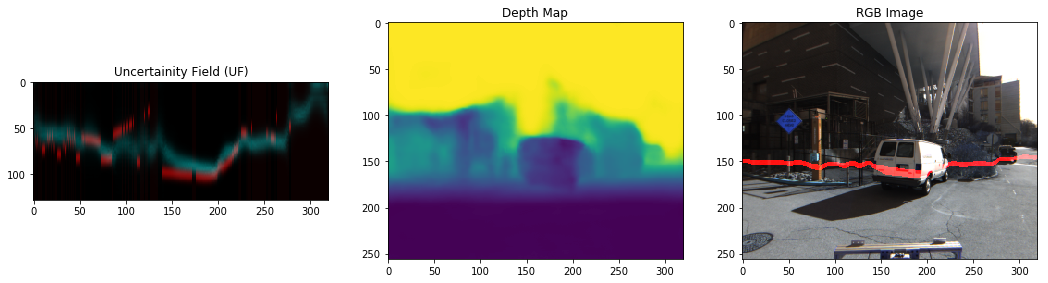

In [10]:
# Visualize Unc Field
visualize_unc_field(unc_field_predicted, unc_field_truth, depth_output, debugmap, datum)

<IPython.core.display.Javascript object>


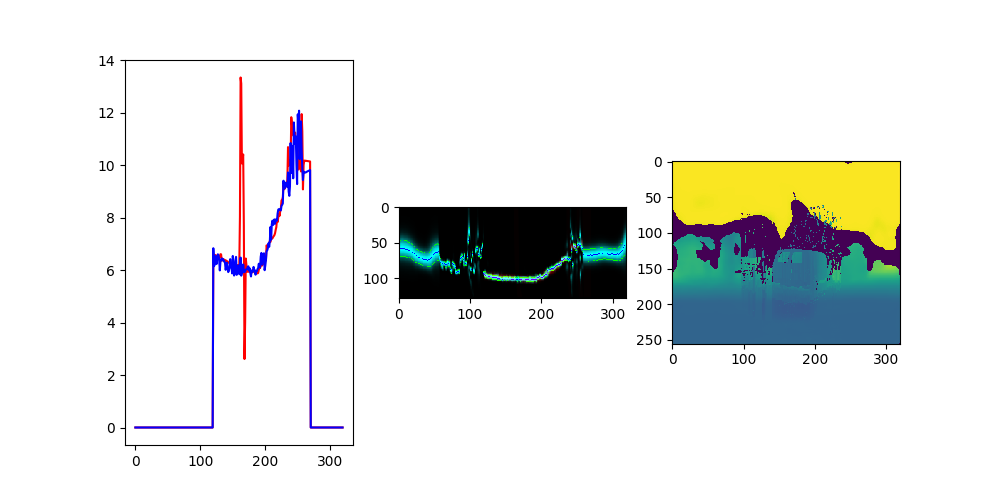

In [52]:
import time
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

class LC():
    def __init__(self, datum):
        param = dict()
        param["intr_rgb"] = datum["large_intr"][0:3,0:3].copy()
        param["intr_lc"] = datum["K_lc_large"].copy()
        param["lTc"] = datum["M_LC2laser"].copy()
        param["rTc"] = datum["M_LC2left"].copy()
        N = len(datum["d_candi_up"])
        param["d_candi"] = datum["d_candi_up"]
        param["d_candi_up"] = param["d_candi"]
        param["r_candi"] = param["d_candi"]
        param["r_candi_up"] = param["d_candi"]
        param['cTr'] = np.linalg.inv(param['rTc'])
        param["device"] = torch.device(0)
        param["size_lc"] = datum["lc_size_large"]
        param["laser_fov"] = 40
        param["laser_timestep"] = 0.000035
        param["dist_lc"] = datum["D_lc"]
        param["size_rgb"] = datum["large_size"]
        param["dist_rgb"] = [0,0,0,0,0]
        param["name"] = "sweep_convert"
        param["expand_A"] = 128
        param["expand_B"] = 128
        param["unc_ang"] = 0.
        param["unc_shift"] = 1.0
        param["unc_span"] = 0.5 # THIS PARAMETER MATTERS ALOT!
        self.real_param = copy.deepcopy(param)
        self.real_lc = light_curtain.LightCurtain()
        if not self.real_lc.initialized:
            self.real_lc.init(copy.deepcopy(self.real_param))

        # Save to Json
        np.save("real_param.npy", self.real_param)

        # Planner LC
        LC_SCALE = float(param['size_rgb'][0]) / float(param['size_lc'][0]) # 0.625
        param['laser_timestep'] = 2.5e-5 / LC_SCALE
        param['intr_lc'] = np.array([
            [param['intr_lc'][0,0]*LC_SCALE, 0, param['intr_lc'][0,2]*LC_SCALE],
            [0, param['intr_lc'][1,1]*LC_SCALE, param['intr_lc'][1,2]*LC_SCALE],
            [0, 0, 1]
        ])
        param['size_lc'] = [int(param['size_lc'][0]*LC_SCALE), int(param['size_lc'][1]*LC_SCALE)]

        # Can we crop the top and bottom?
        TOP_CUT = 72
        BOT_CUT = 72
        param['size_lc'] = [param['size_lc'][0], param['size_lc'][1] - TOP_CUT - BOT_CUT]
        param['intr_lc'][1,2] -=  (TOP_CUT/2 + BOT_CUT/2)

        # Initialize
        self.algo_param = copy.deepcopy(param)
        self.algo_lc = light_curtain.LightCurtain()
        if not self.algo_lc.initialized:
            self.algo_lc.init(copy.deepcopy(self.algo_param))

        # Save to Json
        np.save("algo_param.npy", self.algo_param)

        # Load Flow Field
        self.algo_lc.fw_large.load_flowfield()

        # Pin Memory
        self.intr_r_tensor = torch.tensor(self.real_param['intr_rgb']).cuda()

        # Init Field
        self.init_unc_field()

    def init_unc_field(self):
        init_depth = torch.zeros((1, self.real_param["size_rgb"][1], self.real_param["size_rgb"][0])).cuda() + 10.
        self.final = torch.log(img_utils.gen_dpv_withmask(init_depth, init_depth.unsqueeze(0)*0+1, self.algo_lc.d_candi, 10.0))
        print(self.final.shape)

    def integrate(self, DPVs):
        # Keep Renormalize
        curr_dist = torch.clamp(torch.exp(self.final), img_utils.epsilon, 1.)

        # Update
        for dpv in DPVs:
            dpv = torch.clamp(dpv, img_utils.epsilon, 1.)
            curr_dist = curr_dist * dpv
            curr_dist = curr_dist / torch.sum(curr_dist, dim=1).unsqueeze(1)

        # Spread
        for i in range(0, 1):
            curr_dist = img_utils.spread_dpv_hack(curr_dist, 3)

        # Keep Renormalize
        curr_dist = torch.clamp(curr_dist, img_utils.epsilon, 1.)

        # Back to Log space
        self.final = torch.log(curr_dist)

    def run(self, datum, dpv_r_tensor):

        # Tensors for real sweep
        feat_z_tensor = torch.tensor(datum.sweep_arr_large[:,:,:,0]).cuda()
        feat_int_tensor = torch.tensor(datum.sweep_arr_large[:,:,:,1]).cuda()
        feat_z_tensor[torch.isnan(feat_z_tensor)] = 1000

        # Extract variables
        depth_lc = datum.lc_depth_large
        depth_r_tensor = torch.tensor(datum.left_depth).unsqueeze(0).cuda()
        intr_r_tensor = torch.tensor(datum.large_intr).unsqueeze(0).cuda()

        # Make a DPV out of the Depth Map
        mask_truth = (depth_r_tensor > 0.).float()
        dpv_truth = img_utils.gen_dpv_withmask(depth_r_tensor, mask_truth.unsqueeze(0), self.algo_lc.d_candi, 0.1)
        depth_truth = img_utils.dpv_to_depthmap(dpv_truth, self.algo_lc.d_candi, BV_log=False) * mask_truth

        # Make Unc Field Truth (RGB) (LC)
        unc_field_truth_r, debugmap = img_utils.gen_ufield(dpv_truth, self.algo_lc.d_candi, intr_r_tensor.squeeze(0), BV_log=False, cfgx=self.real_param)
        unc_field_truth_lc = self.algo_lc.fw_large.preprocess(unc_field_truth_r.squeeze(0), self.algo_lc.d_candi, self.algo_lc.d_candi_up)
        unc_field_truth_lc = self.algo_lc.fw_large.transformZTheta(unc_field_truth_lc, self.algo_lc.d_candi_up, self.algo_lc.d_candi_up, "transform_" + "large").unsqueeze(0)
        unc_field_truth_lc[:,:,0:50] = np.nan
        unc_field_truth_lc[:,:,-50:-1] = np.nan

        # Setup Planner
        params = {"step": [0.5], "std_div": 5.}
        plan_func = self.algo_lc.plan_default
        #params = {"step": 3, "interval": 15, "std_div": 3.}
        #plan_func = self.algo_lc.plan_m1

        # Expand and Integrate
        dpv_r_tensor = torch.exp(img_utils.upsample_dpv(dpv_r_tensor, N=self.real_lc.expand_A, BV_log=True))
        for i in range(0,1):
            self.integrate([dpv_r_tensor])      

        # Hack
        # self.final = torch.log(img_utils.gen_dpv_withmask(self.final[:,0,:,:]*0+10, self.final[:,0,:,:].unsqueeze(0)*0+1, self.algo_lc.d_candi, 3.0))

        # Sensing
        iterations = 10
        for i in range(0, iterations):

            # Generate UField (in RGB)
            unc_field_predicted_r, debugmap = img_utils.gen_ufield(self.final, self.algo_lc.d_candi, intr_r_tensor.squeeze(0), BV_log=True, cfgx=self.real_param)

            # Remove stuff
            unc_field_truth_lc[:,:,0:120] = np.nan
            unc_field_truth_lc[:,:,270:320] = np.nan

            # Score (Need to compute in LC space as it is zoomed in sadly)
            unc_field_predicted_lc = self.algo_lc.fw_large.preprocess(unc_field_predicted_r.squeeze(0), self.algo_lc.d_candi, self.algo_lc.d_candi_up)
            unc_field_predicted_lc = self.algo_lc.fw_large.transformZTheta(unc_field_predicted_lc, self.algo_lc.d_candi_up, self.algo_lc.d_candi_up, "transform_" + "large").unsqueeze(0)
            gt_plot, pred_plot = img_utils.compute_unc_rmse_cust(unc_field_truth_lc, unc_field_predicted_lc, self.algo_lc.d_candi)
            
            # RGB Debug
            rgb_debug = datum["left_img"].copy().astype(np.float32)/255
            rgb_debug[:,:,0] += debugmap[0,:,:].detach().cpu().numpy()

            # Plan Paths
            lc_paths = list(plan_func(unc_field_predicted_r.squeeze(0), self.algo_lc.planner_large, self.algo_lc.fw_large, "high", params, yield_mode=True))

            # Generate DPV
            lc_DPVs = []
            for lc_path in lc_paths:
                # Simulated Measurement
                output_lc, thickness_lc = self.real_lc.lightcurtain_large.get_return(depth_lc, lc_path, True)
                output_lc[np.isnan(output_lc[:, :, 0])] = 0
                thickness_lc[np.isnan(thickness_lc[:, :])] = 0

                # Sampling intensities from real sensor
                sampling_depth = torch.tensor(output_lc[:,:,2]).cuda()
                inds = torch.argmin(torch.abs(sampling_depth.reshape(1, sampling_depth.shape[0], sampling_depth.shape[1]) - feat_z_tensor), dim=0)
                result = torch.gather(feat_int_tensor, 0, inds.unsqueeze(0)).squeeze(0)
                output_lc[:,:,3] = result.cpu().numpy()

                # Transform to LC
                sensed_arr = self.real_lc.transform_measurement(output_lc, thickness_lc)

                # Gen DPV
                #peak_img = torch.clamp(datum.nir_warped_tensor.squeeze(0) + 0.2, 0, 1)
                peak_img = None
                lc_DPV = self.real_lc.gen_lc_dpv_approx(sensed_arr, 5) # May have to pass values here
                # lc_DPV = self.real_lc.gen_lc_dpv_true(sensed_arr, 2, peak_img) # May have to pass values here
                # Add
                lc_DPVs.append(lc_DPV)

            # Integrate Measurement
            self.integrate(lc_DPVs)

            # Gen Depth removing uncertainties
            z = torch.exp(self.final.squeeze(0))
            d_candi_expanded = torch.tensor(self.algo_lc.d_candi).unsqueeze(1).unsqueeze(1).cuda()
            mean = torch.sum(d_candi_expanded * z, dim=0)
            variance = torch.sum(((d_candi_expanded - mean) ** 2) * z, dim=0)
            mask_var = (variance < 2.0).float()
            final_depth = (mean * mask_var).cpu().numpy()

            # Return
            field_visual = self.algo_lc.field_visual
            field_visual[:,:,2] = unc_field_truth_lc[0,:,:].cpu().numpy()*3
            field_visual = cv2.flip(field_visual, 0)
            field_visual = field_visual[:,:,::-1]
            
            # Print
            out1 = axes[0].plot(gt_plot, c='red')
            out2 = axes[0].plot(pred_plot, c='blue')
            axes[1].imshow(field_visual)
            axes[2].imshow(final_depth/100)
            fig.canvas.draw()
            time.sleep(1)
            
            if i != iterations-1:
                for line in axes[0].get_lines(): # ax.lines:
                    line.remove()
            #out1.remove()
            #out2.remove()
            
            #plt.imshow(field_visual)
            #cv2.imshow("rgb_debug", rgb_debug)
            #cv2.imshow("final_depth", final_depth/100)
            #cv2.waitKey(0)

        # Squeeze back to 64
        return img_utils.upsample_dpv(self.final, N=64, BV_log=True) 

        pass

In [53]:
# Setup LC
lc = LC(datum)
corrected_dpv = lc.run(datum, dpv_output)

torch.Size([1, 128, 256, 320])
